In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

### Задание

1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
2. Добавьте первые разности по стоимости доллара и евро к рублю
3. сделайте ее перрасчет (ресемплинг) в представление по неделям. 
4. Постройте модель предсказания 1-й точки от текущей (h=1).

5. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [2]:
brent_data = pd.read_csv('my_BRENT2019.csv')
brent_data.index = pd.DatetimeIndex(brent_data['Дата'])
brent_data = brent_data.drop(columns=['Дата'])
brent_data

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-08-27,59.59,2019,8,27,3,239,35,1,0,0,0
2019-08-28,59.84,2019,8,28,3,240,35,2,0,0,0
2019-08-29,60.37,2019,8,29,3,241,35,3,0,0,0


In [3]:
brent_data['diff1'] = brent_data['Значение'].diff(1)

In [4]:
# создаем датафрейм первых разностей
df = pd.DataFrame(index=brent_data.index)
df['diff1'] = brent_data['diff1']
df['dayofweek'] = brent_data['dayofweek']
df.fillna(0 , inplace=True)

In [5]:
# сразу добавим историю на глубину 8   
p = 8
for i in range(p):
    df['t_'+str(p-i)] = 0.0
    df['t_'+str(p-i)].values[p:] = df['diff1'].values[i:-(p)+i]

In [6]:
df.shape

(2667, 10)

In [7]:
df_d = df.resample('W').mean()
df_d.shape

(470, 10)

### Добавим разности курсов евро и доллара по отношению к рублю

In [8]:
rub_doll=pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx')
rub_doll.index = pd.to_datetime(rub_doll['data'].values).date
rub_doll.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_doll.shape

(2228, 1)

In [9]:
rub_e=pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx')
rub_e.index = pd.to_datetime(rub_e['data'].values).date
rub_e.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_e.shape

(2228, 1)

In [10]:
rub_doll['rub_doll_diff1'] = rub_doll['curs'].diff(1)
rub_e['rub_e_diff1'] = rub_e['curs'].diff(1)

In [11]:
df = pd.concat([df, rub_doll['rub_doll_diff1'], rub_e['rub_e_diff1']], axis=1)

In [12]:
df.shape

(3137, 12)

In [13]:
# как видим строк стало больше, это связано с добавлением новых строк из данных по курсам валют

### сделаем недельный ресеплинг и проверим на пропуски

In [14]:
df_w = df.resample('W').mean()
df_w.shape

(470, 12)

In [15]:
df_w.isnull().sum()

diff1             1
dayofweek         1
t_8               1
t_7               1
t_6               1
t_5               1
t_4               1
t_3               1
t_2               1
t_1               1
rub_doll_diff1    8
rub_e_diff1       8
dtype: int64

In [16]:
# в данном случае просто избавимся от строк с пропускми, их все 9

In [17]:
df_w = df_w.dropna()

In [18]:
df_w.shape

(461, 12)

In [19]:
# тут можно еще добавить историю по курсам 

### поделим данные

In [20]:
def split_data( data, split_date ):
    return data.iloc[:split_date,:].copy(), data.iloc[split_date:,:].copy()

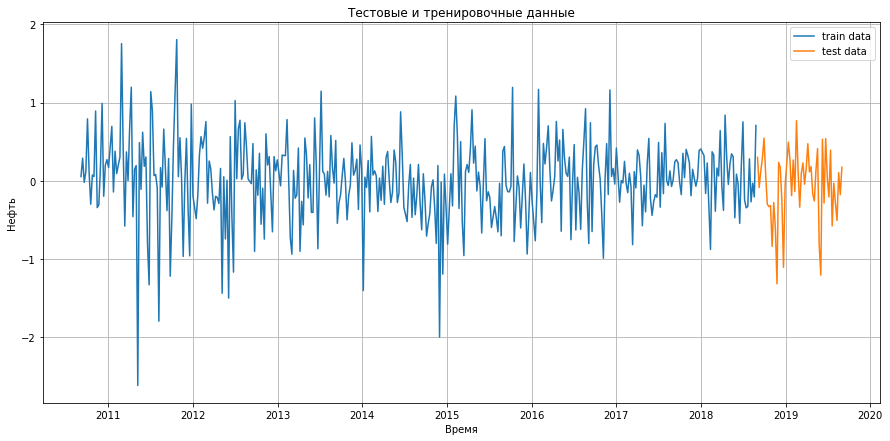

In [21]:
train, test = split_data(df_w, -52)

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(train.index,train.iloc[:,0], label='train data' )
plt.plot(test.index,test.iloc[:,0], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.grid()
plt.legend()
plt.show()

In [22]:
X_train = train.iloc[:-1,:]
y_train = train['diff1'].values[1:]
X_test = test.iloc[:-1,:]
y_test = test['diff1'].values[1:]

### Построим модель

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

In [24]:
model = GradientBoostingRegressor(max_depth=13, random_state=21, n_estimators=500)

In [25]:
model.fit(X_train, y_train) 

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=13,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [26]:
y_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

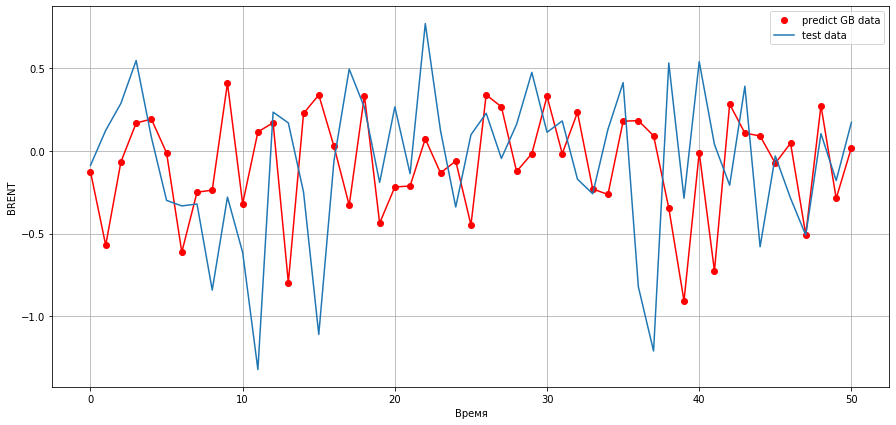

In [27]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred[:100],'or', label='predict GB data' )
plt.plot(y_test_pred[:100],'r' )
plt.plot(y_test[:100], label='test data')
plt.grid()
plt.legend()
plt.show()

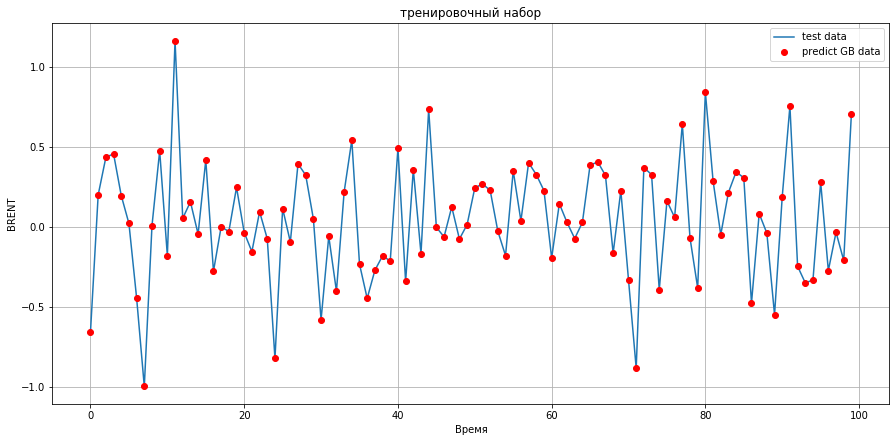

In [28]:
plt.figure( figsize=( 15, 7 ))
plt.title('тренировочный набор')
plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_train[-100:], label='test data')
plt.plot(y_pred[-100:],'or', label='predict GB data' )
plt.grid()
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [30]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   192.0471384616226 %
